# == Two-channel CNN for binary Classification ==


In [1]:
# Computational Intelligence Project
# Dipartimento di Ingegneria dell´Informazione , Universita´ di Pisa
# Authors: Rachele Nebbia Colomba, Alessandro Gentili, Giorgio Simonini
#    begin                : June 2020
#    copyright            : (C)  2020 Universita´ di pisa    
#    email                : rachelenebbia <at> gmail <dot> com

# Import libraries
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from google.colab import drive
from tensorflow.keras.models import load_model


TensorFlow 1.x selected.
1.15.2
2.2.4-tf


Using TensorFlow backend.


In [ ]:
#Function to shuffle the tuples and have random order of the classes in training dataset
def mischia(img,lab):
    z=list(zip(img,lab)) #zip returns an iterator instead and needs to be passed to a list function to get the zipped tuples
    rnd.shuffle(z) #random shuffle of the tuples
    img2,lab2=zip(*z) #unzipping, it obtaines the original form 
    img2=np.asarray(img2)
    lab2=np.asarray(lab2)
    return img2,lab2

In [3]:
# Import data
drive.mount('/content/drive/')

dir_numpy ="/content/drive/My Drive/Computational/numpy data"
dir_nets ="/content/drive/My Drive/Computational/networks"
dir_check ="/content/drive/My Drive/Computational/networks"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


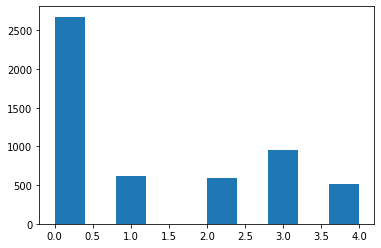

5352 images


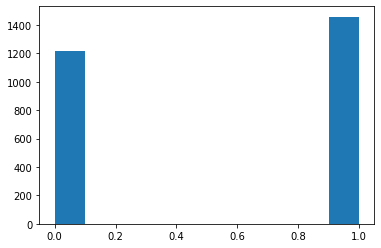

2676 images


In [4]:
# Load tensor for Training Dataset (images+labels) and Testing Dataset (images+labels)
train_img = np.load(os.path.join(dir_numpy,'train_tensor.npy'))
train_lab = np.load(os.path.join(dir_numpy,'train_labels.npy'))
test_img = np.load(os.path.join(dir_numpy,'public_test_tensor.npy'))
test_lab = np.load(os.path.join(dir_numpy,'public_test_labels.npy'))

# Plot histogram to visualize classes distribution of Dataset
plt.hist(train_lab)
plt.show()
print(len(train_lab), "images")

# # Here define new tensors to divide between massesn and calcifications:
# Labels legend --> 2 = masses, 4 = calcifications.
n_img=len(train_img)
train_img_4a=train_img[1:n_img:2]
train_img_4b=train_img[0:n_img:2]
n_img_test=len(test_img)
test_img_4a=test_img[1:n_img_test:2]
test_img_4b=test_img[0:n_img_test:2]
# From tensor get labels
train_lab_4=train_lab[1:n_img:2]
test_lab_4=test_lab[1:n_img_test:2]
n_img4=len(train_img_4a)

# Processing: reassign labels to have mass = 0, calcification = 1
for i in range(0,n_img4):
    if ((train_lab_4[i] == 1) or (train_lab_4[i] == 2)):
        train_lab_4[i] = 0
    elif ((train_lab_4[i] == 3) or (train_lab_4[i] == 4)):
        train_lab_4[i] = 1
n_img4_test=len(test_img_4a)
for i in range(0,n_img4_test):
    if ((test_lab_4[i] == 1) or (test_lab_4[i] == 2)):
        test_lab_4[i] = 0
    elif ((test_lab_4[i] == 3) or (test_lab_4[i] == 4)):
        test_lab_4[i] = 1
#Plot histogram to visualize data distribution 
plt.hist(train_lab_4)
plt.show()
print(len(train_lab_4), "images")

In [5]:
# Design of NN neutwork
# Add convolutional, pooling and dense layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________

In [6]:
#Compile CNN with optimizer and chosen metric 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


float32


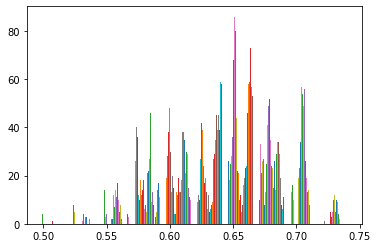

(336, 150, 150, 1)

In [7]:

# Normalize train and test images 
train_img_4a = train_img_4a.astype('float32') / 65535
train_img_4b = train_img_4b.astype('float32') / 65535
test_img_4a = test_img_4a.astype('float32') / 65535
test_img_4b = test_img_4b.astype('float32') / 65535

# Visualize processing
print(train_img_4a[5,:].dtype) # check the type
plt.hist(train_img_4a[5,:]) # check the value range and the distribution
plt.show()

# reshape datasets
train_img_4a = train_img_4a.reshape((n_img4, 150, 150, 1))
train_img_4b = train_img_4b.reshape((n_img4, 150, 150, 1))
test_img_4a = test_img_4a.reshape((n_img4_test, 150, 150, 1))
test_img_4b = test_img_4b.reshape((n_img4_test, 150, 150, 1))

# Build two channels:
# first channel --> baseline patches, second channel --> abnormality patches 
train_img_4 = np.ndarray(shape=(train_img_4a.shape[0], train_img_4a.shape[1], train_img_4a.shape[2], 2), dtype= np.float32) #dummy RGB images
train_img_4[:, :, :, 0] = train_img_4a[:, :, :, 0]
train_img_4[:, :, :, 1] = train_img_4b[:, :, :, 0]

test_img_4 = np.ndarray(shape=(test_img_4a.shape[0], test_img_4a.shape[1], test_img_4a.shape[2], 2), dtype= np.float32) #dummy RGB images
test_img_4[:, :, :, 0] = test_img_4a[:, :, :, 0]
test_img_4[:, :, :, 1] = test_img_4b[:, :, :, 0]

test_img_4a.shape

In [8]:
# reshap train dataset into vector 
train_lab_4.shape

(2676,)

In [9]:
# Visualize labels for first 100 samples
train_lab_4.shape
print(train_lab_4[0:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# Shuffle samples to have random order of classes
train_img_4, train_lab_4 = mischia(train_img_4, train_lab_4)
train_lab_4.shape
# Visualize first 100 samples after shuffling 
print(train_lab_4[0:100])

[1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1
 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0
 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1]


In [11]:
# Start training with Ccheckpoint, number of epochs and validation split definition 
file_check ="/content/drive/My Drive/Computational/networks/checkpoint4"
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
checkpoint = ModelCheckpoint(file_check, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_img_4, 
                    train_lab_4, 
                    epochs=50, 
                    batch_size=228,
                    validation_split=0.15,
                    shuffle = True,
                    callbacks=[checkpoint])

Train on 2274 samples, validate on 402 samples
Epoch 1/50
2052/2274 [==========================>...] - ETA: 1s - loss: 0.6713 - acc: 0.5843
Epoch 00001: val_acc improved from -inf to 0.66667, saving model to /content/drive/My Drive/Computational/networks/checkpoint4
2274/2274 [==============================] - 19s 8ms/sample - loss: 0.6696 - acc: 0.5875 - val_loss: 0.6408 - val_acc: 0.6667
Epoch 2/50
2052/2274 [==========================>...] - ETA: 0s - loss: 0.6354 - acc: 0.6613
Epoch 00002: val_acc improved from 0.66667 to 0.67164, saving model to /content/drive/My Drive/Computational/networks/checkpoint4
2274/2274 [==============================] - 3s 1ms/sample - loss: 0.6388 - acc: 0.6570 - val_loss: 0.6254 - val_acc: 0.6716
Epoch 3/50
2052/2274 [==========================>...] - ETA: 0s - loss: 0.6190 - acc: 0.6784
Epoch 00003: val_acc improved from 0.67164 to 0.68408, saving model to /content/drive/My Drive/Computational/networks/checkpoint4
2274/2274 [=========================

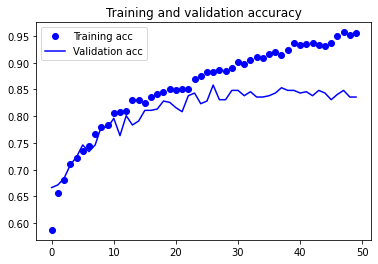

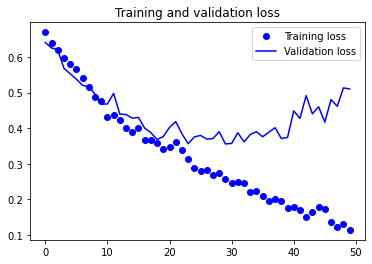

In [12]:
# Visualize results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot training and validation accuracy 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
# Evaluate results on Test Dataset
test_loss, test_acc = model.evaluate(test_img_4, test_lab_4)

336/336 [==============================] - 1s 2ms/sample - loss: 0.6071 - acc: 0.8482


In [ ]:
#ckmodel.save(os.path.join(dir_nets,"net_4.h5"))

In [15]:
ckmodel = load_model(os.path.join(dir_check,"checkpoint4"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
test_loss, test_acc = ckmodel.evaluate(test_img_4, test_lab_4)

336/336 [==============================] - 0s 682us/sample - loss: 0.4772 - acc: 0.7887


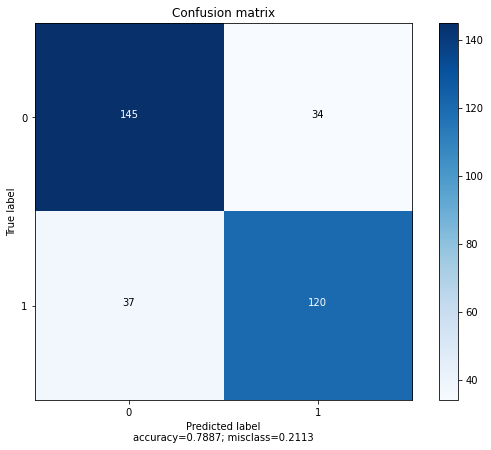

In [18]:
# Results evaluation: 
# Confusion Matrix plot
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
#Plotting of the Matrix confusion
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xticks(range(0,2),)
    plt.yticks(range(0,2),)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
 
y_pred=ckmodel.predict(test_img_4)
for i in range(len(test_lab_4)):
  if y_pred[i] <= 0.5:
    y_pred[i]=0
  else:
    y_pred[i]=1
conf_mtx = confusion_matrix(test_lab_4,y_pred) 
plot_confusion_matrix(conf_mtx,normalize=False)

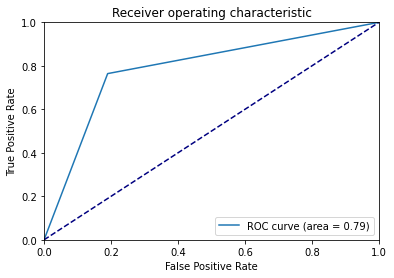

In [19]:
# Results evaluation: 
# ROC Curve plot
fpr,tpr,th = metrics.roc_curve(test_lab_4,y_pred)
# Sensitivty = TPR(True Positive Rate)= Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate)= FP/(TN+FP)
 
roc_auc = metrics.roc_auc_score(test_lab_4,y_pred)
from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()